In [1]:
#https://towardsdatascience.com/music-in-python-2f054deb41f4

In [122]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import pandas as pd
from scipy.signal import find_peaks

In [123]:
%ls

 Le volume dans le lecteur C s’appelle System
 Le numéro de série du volume est A698-0041

 Répertoire de C:\Users\mceau\Documents\harmonics

02/05/2022  15:23    <DIR>          .
02/05/2022  15:23    <DIR>          ..
02/05/2022  13:35    <DIR>          .ipynb_checkpoints
02/05/2022  09:51    <DIR>          __pycache__
29/04/2022  10:01    <DIR>          archive
02/05/2022  15:23            44 127 AUDIO.ipynb
02/05/2022  09:51            28 959 config.yaml
02/05/2022  09:51    <DIR>          data
02/05/2022  09:51           140 880 EXTRACT.ipynb
02/05/2022  14:17            62 366 flute_A.wav
02/05/2022  15:27    <DIR>          harmonics
02/05/2022  09:51             2 555 INTERVALS.ipynb
02/05/2022  14:46           176 444 name.wav
02/05/2022  14:23           220 544 synthetic_a.wav
02/05/2022  09:51         1 420 477 TENSORFLOW_TUTO.ipynb
               8 fichier(s)        2 096 352 octets
               7 Rép(s)  889 272 078 336 octets libres


In [374]:
class Wave:
    def __init__(self,frequency,sample_rate=44100,amplitude=4096,file=None):
        self.frequency      = frequency
        self.sample_rate    = sample_rate
        self.amplitude      = amplitude
        self.file           = file
        self._analyzed = {'file':[],'data':[],'fourier':[],'harmonics':[],'rel_harmonics':[],'fundamental':[],'note':[],'offpitch':[]}
    
    @property
    def analyzed(self):
        return pd.DataFrame({k:pd.Series(v) for k,v in self._analyzed.items()})
    
    def _get_sine(self,duration,a=1,f=1):
        t = np.linspace(0, duration, int(self.sample_rate*duration)) # Time axis
        wave = (a*self.amplitude)*np.sin(2*np.pi*(self.frequency*f)*t)
        return wave
        
    def get_wave(self,duration,overtones=False,plot=True,wav=True,filename='name.wav',samples='all'):
        if not overtones:
            wave = self._get_sine(duration)
        else:
            if type(overtones) == int:
                harmonics = self.analyzed.loc[overtones,'rel_harmonics']
            else:
                harmonics = overtones
            wave = np.sum([self._get_sine(duration,a=a,f=f) for f,a in harmonics],axis=0)
        if plot:
            self._plot(np.arange(len(wave))/self.sample_rate,wave,'time','amplitude',samples=samples)
        if wav:
            wavfile.write(filename, rate=self.sample_rate, data=wave.astype(np.int16))
        return wave
    
    def _plot(self,x,y,xlabel='',ylabel='',title='',samples='all'):
        if samples != 'all': x = x[:samples] ; y = y[:samples]
        plt.figure()
        plt.plot(x,y)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.title(title)
        plt.grid()
        
    def extract_overtones(self,filepath,plot=True):
        sample_rate, data = wavfile.read(filepath)
        self._analyzed['file'].append(filepath)
        self._analyzed['data'].append(data)
        if plot: self._plot(np.arange(len(data))/sample_rate,data,'Time','Amplitude',filepath)
        t    = np.arange(data.shape[0])
        freq = np.fft.rfftfreq(t.shape[-1])*sample_rate
        sp   = np.fft.rfft(data) 
        if plot: self._plot(freq,abs(sp.real),'Frequency (Hz)','Amplitude',filepath)
        df = pd.DataFrame(np.vstack((freq,abs(sp))).T,columns=['frequency','amplitude'])#.sort_values('amplitude',ascending=False)
        self._analyzed['fourier'].append(df)
        max_freq = df[df.amplitude == df.amplitude.max()].frequency
        a, _ = find_peaks(df.amplitude,threshold=df.amplitude.max()*0.01,distance=int(max_freq/900*100))
        f = df.loc[a,:]
        f.sort_values('frequency',inplace=True)
        harmonics = [(round(a,2),round(b,2)) for a,b in zip(f.frequency,f.amplitude)] ; print(harmonics)
        self._analyzed['harmonics'].append(harmonics)
        fundamental = round(f.frequency.to_numpy()[0],2)
        self._analyzed['fundamental'].append(fundamental)
        rel_h = [(round(a/fundamental,2), round(b/f.amplitude.max(),2)) for a,b in harmonics]
        self._analyzed['rel_harmonics'].append(rel_h) ; print(rel_h)
        note = h.Note(str(fundamental)+'Hz')
        self._analyzed['note'].append(note)
        self._analyzed['offpitch'].append(note.pitch.offpitch)

[(15.83, 12.81), (114.29, 75.68), (207.49, 102.51), (341.12, 60.7), (441.35, 94.99), (603.12, 50.13), (722.69, 13.82), (835.23, 5.35), (975.9, 3.37), (1142.94, 2.69), (1260.75, 3.39), (1496.37, 2.99), (2787.02, 4.79), (3073.63, 6.24), (3214.3, 2.93), (3314.53, 2.46)]
[(1.0, 0.12), (7.22, 0.74), (13.11, 1.0), (21.55, 0.59), (27.88, 0.93), (38.1, 0.49), (45.65, 0.13), (52.76, 0.05), (61.65, 0.03), (72.2, 0.03), (79.64, 0.03), (94.53, 0.03), (176.06, 0.05), (194.16, 0.06), (203.05, 0.03), (209.38, 0.02)]


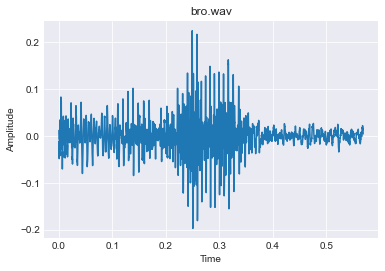

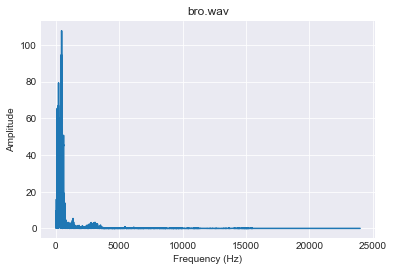

In [375]:
w = Wave(220)
w.extract_overtones('bro.wav')

In [378]:
o = [(1,1)]+[(i,1/i) for i in range(3,1000,2)]

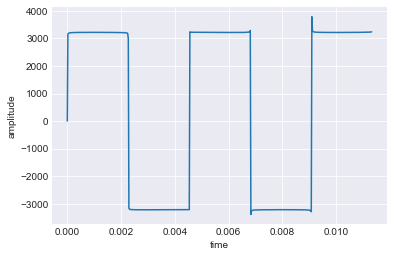

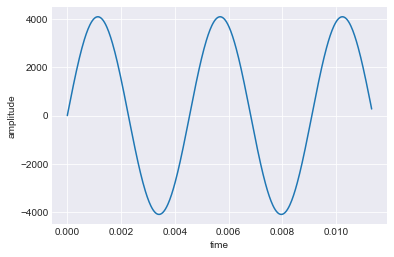

In [381]:
a = w.get_wave(2,overtones=o,samples=500) + w.get_wave(2,overtones=None,samples=500)

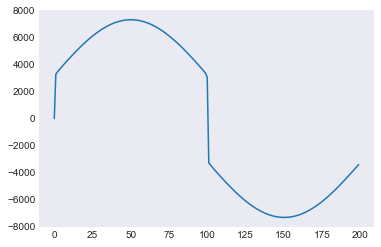

In [384]:
plt.plot(a[:200])